In [1]:
from __future__ import print_function
import numpy as np
import numpy.linalg as LA
from scipy import optimize
#from maxvolpy.maxvol import rect_maxvol, maxvol
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import gen_mat as gen
import grad_log_det as log_det # this is a module with analytical calculation of gradient and objective 
#from autograd import grad
from numba import jit, njit, prange
from mva_test import *
import os
import itertools
import fnmatch
import re
%matplotlib inline

# Load points and calc Lebesge constant

## Load

In [2]:
def plot_pnts(pnts, color='r'):
    if pnts.shape[1] == 2:
        plt.figure(figsize=(8, 8))
        plt.plot(pnts[:, 0],  pnts[:, 1], color + '.', ms=10);

dir_fn = 'res_IPOPT/'
# dir_fn = 'GD/'
fn_template = 'cols=(\d+)_points=(\d+)_poly=(.+?)\.npz'
types_tmpl = (int, int, str)
re_tmpl = re.compile(fn_template)
all_files = os.listdir(dir_fn)
print(all_files[0])

cols=37_points=66_poly=trigpoly.npz


In [3]:
data = dict()
types_tmpl_n = len(types_tmpl)
vals = [[] for _ in types_tmpl]
for fnc in all_files:
    fnd = re_tmpl.match(fnc)
    # print(fnc)
    if not fnd:
        continue
    cur_val = []
    for i, tp in enumerate(types_tmpl):
        val = tp(fnd.group(i+1))
        cur_val.append(val)
        if val not in vals[i]:
            vals[i].append(val)
            
    data[tuple(cur_val)] = np.load(dir_fn + fnc)['pnts']
    dim = data[tuple(cur_val)].shape[1]

In [4]:
for i in vals:
    print(i)

[37, 10, 5, 21, 36, 40, 50, 20, 15, 45]
[66, 56, 61, 72, 25, 46, 79, 68, 52, 37, 70, 51, 22, 21, 55, 65, 54, 15, 63, 67, 41, 49, 45, 64, 44, 39, 33, 38, 32, 40, 78, 6, 73, 34, 62, 28, 16, 19, 58, 42, 27, 59, 53, 76, 60, 77, 48, 31, 71, 20, 69, 50, 36, 57, 26, 75, 14, 35, 74, 29, 13, 11, 12, 23, 17, 9, 47, 7, 24, 10, 18, 30, 43, 5, 8]
['trigpoly', 'cheb', 'herm_nn']


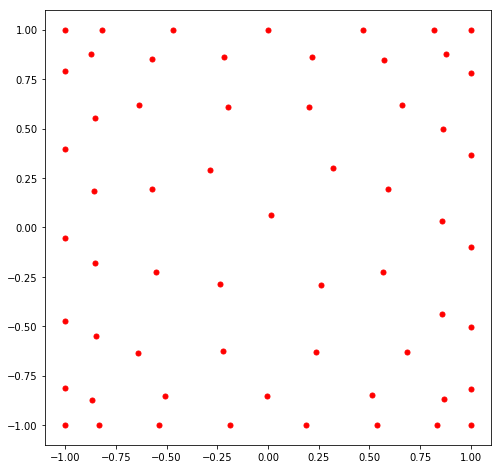

In [5]:
p_pnts = data[(10, 60, 'cheb')]
# plt.plot(p_pnts[:, 0],  p_pnts[:, 1], 'r.');
plot_pnts(p_pnts)

## Lebesge

In [6]:
# Just test

n_cols = 50
n_pnts = 60

# dim = 2
np.random.seed(42)
# myfunc = lambda x, y : f_sincos(5*x, 5*y)
test_pnts = test_points_gen(int(1e5), dim)

pnts = data[(n_cols, n_pnts, 'cheb')]
LC_ipopt = LebesgueConst(pnts, n_cols, poly=gen.cheb, test_pnts=test_pnts)
print(LC_ipopt)

np.random.seed(43)
LHS_pnts = test_points_gen(n_pnts, dim, distrib='LHS')
LC_LHS = LebesgueConst(LHS_pnts, n_cols, poly=gen.cheb, test_pnts=test_pnts)

print(LC_LHS)

2.256591784463822
129.10236643014838


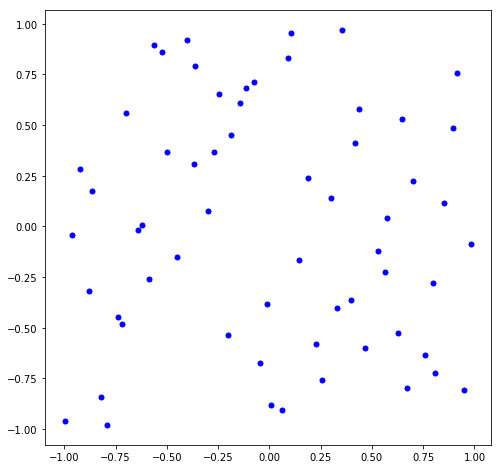

In [7]:
plot_pnts(LHS_pnts, 'b')

## Plot Lebesgue

In [8]:
fn_LC = dir_fn + 'LC_ipopt'
fn_LC_npz = fn_LC + '.npz'
if os.path.exists(fn_LC_npz):
    LCs_ipopt = np.load(fn_LC_npz)['LC'].item()
    print('Data is loaded')
else:
    LCs_ipopt = dict()
    for ncols in vals[0]:
        for npnts in vals[1]:
            key = (ncols, npnts, 'cheb')
            try:
                #print(col, n_pnts)
                pnts = data[key]
                LCs_ipopt[key] = LebesgueConst(pnts, ncols, poly=gen.cheb, test_pnts=test_pnts)    
            except:
                pass
    np.savez(fn_LC, LC=LCs_ipopt)
  

In [9]:
def make_slice(ncol, data=LCs_ipopt, poly='cheb'):
    res = np.empty((len(vals[1]), 2))
    x = np.array(vals[1])
    x.sort()
    res[:, 0] = x
    res[:, 1] = np.nan

    for i, n_pnts in enumerate(x):
        try:
            res[i, 1] = data[(ncol, n_pnts, poly)]
        except:
            pass
    return res[~np.isnan(res[:, 1])]

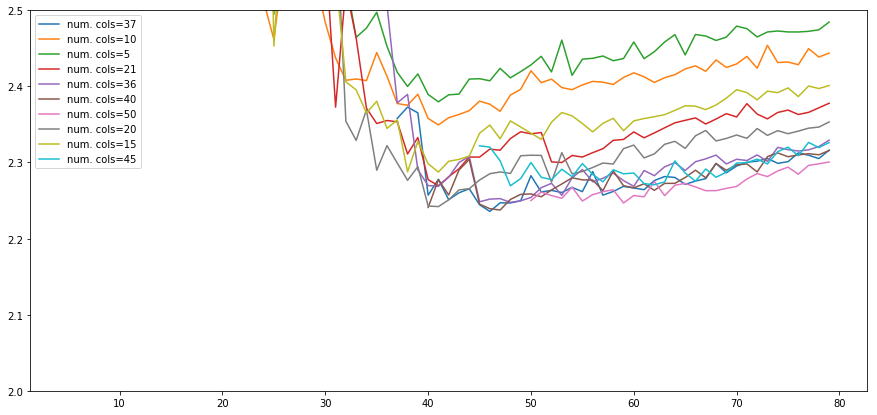

In [10]:
plt.figure(figsize=(15, 7))
for ncol in vals[0]:
    ll = make_slice(ncol)
    plt.plot(ll[:, 0], ll[:, 1], label='num. cols={}'.format(ncol))

plt.legend();
plt.ylim([2,2.5]);

# Old

In [11]:
all_files = os.listdir("/Users/vitaly/Downloads/maxvol-approximation/res_IPOPT/")

In [12]:
cheb = []
trigpoly = []
herm = []
for i in all_files:
    if fnmatch.fnmatch(i, '*_poly=cheb*'):
        cheb.append(i)
    if fnmatch.fnmatch(i, '*_poly=herm_nn*'):
        herm.append(i)
    if fnmatch.fnmatch(i, '*_poly=trigpoly*'):
        trigpoly.append(i)

In [13]:
srch = re.search('cols=(\d+)_points=(\d+)_',cheb[0])

In [14]:
srch.group(1)

'10'

In [15]:
{int(re.search('cols=(\d+)_points=(\d+)_', fn).group(1)) for fn in cheb}

{5, 10, 15, 20, 21, 36, 37, 40, 45, 50}

In [16]:
tol = 1e-12
def loss_func(points, num_col, poly=gen.cheb, ToGenDiff=False):
    if (points.ndim == 1 or points.shape[1] == 1):
        points = points.reshape(-1, dim, order='F')
    A = gen.GenMat(num_col, points, poly=poly, ToGenDiff=ToGenDiff)
    S = LA.svd(A, compute_uv = False)
    S[ S < tol ] = tol
    ld = 2.0*np.sum(np.log(S))
    return -ld

In [19]:
dim = 2
np.random.seed(42)
myfunc = lambda x, y : f_sincos(5*x, 5*y)
test_pnts = test_points_gen(int(1e5), dim)

ff = MakeValsAndNorms([myfunc], test_pnts)

SCIPY_C_logdet = np.NaN*np.ones((79+1,50+1))

SCIPY_C_lebesgue = np.NaN*np.ones((79+1,50+1))
SCIPY_C_error = np.NaN*np.ones((79+1,50+1))
SCIPY_C_clusters = np.NaN*np.ones((79+1,50+1))
for i in cheb:
    n_col = int(re.search('cols=(\d+)_points=(\d+)_', i).group(1))
    n_pnts = int(re.search('cols=(\d+)_points=(\d+)_', i).group(2))
    pnts = np.load("/Users/vitaly/Downloads/maxvol-approximation/GD/"+i)['pnts']
    buf = LebesgueConst(pnts, n_col, poly=gen.cheb, test_pnts=test_pnts, pow_p=1, funcs=ff, derivative=False)
    
    SCIPY_C_logdet[n_pnts,n_col] = loss_func(pnts, num_col = n_col)
    
    SCIPY_C_lebesgue[n_pnts,n_col] = buf[0]
    SCIPY_C_error[n_pnts,n_col] = buf[1]
    SCIPY_C_clusters[n_pnts,n_col] = NumOfClusters(pnts, full=False)

In [21]:
dim = 2
np.random.seed(42)
test_pnts = test_points_gen(int(1e5), dim)

ff = MakeValsAndNorms([myfunc], test_pnts)

IPOPT_C_logdet = np.NaN*np.ones((79+1,50+1))

IPOPT_C_lebesgue = np.NaN*np.ones((79+1,50+1))
IPOPT_C_error = np.NaN*np.ones((79+1,50+1))
IPOPT_C_clusters = np.NaN*np.ones((79+1,50+1))
for i in cheb:
    n_col = int(re.search('cols=(\d+)_points=(\d+)_', i).group(1))
    n_pnts = int(re.search('cols=(\d+)_points=(\d+)_', i).group(2))
    pnts = np.load("/Users/vitaly/Downloads/maxvol-approximation/res_IPOPT/"+i)['pnts']
    buf = LebesgueConst(pnts, n_col, poly=gen.cheb, test_pnts=test_pnts, pow_p=1, funcs=ff, derivative=False)

    IPOPT_C_logdet[n_pnts,n_col] = loss_func(pnts, num_col = n_col)
    
    IPOPT_C_lebesgue[n_pnts,n_col] = buf[0]
    IPOPT_C_error[n_pnts,n_col] = buf[1]
    IPOPT_C_clusters[n_pnts,n_col] = NumOfClusters(pnts, full=False)

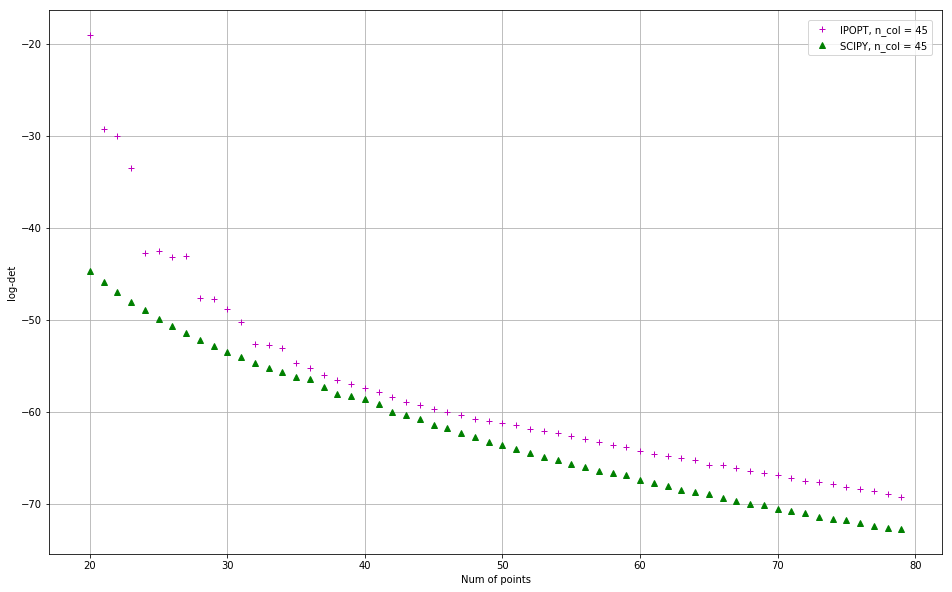

In [22]:
_, fig = plt.subplots(figsize=(16, 10))

plt.plot(range(80),IPOPT_C_logdet[:,20],'m+', label = 'IPOPT, n_col = 45')
plt.plot(range(80),SCIPY_C_logdet[:,20],'g^', label = 'SCIPY, n_col = 45')
plt.xlabel('Num of points')
plt.ylabel('log-det')
plt.legend(ncol=1, borderaxespad=1)
plt.grid()
# plt.savefig('/Users/vitaly/Desktop/log-det.png', pdi = 600)
plt.show()

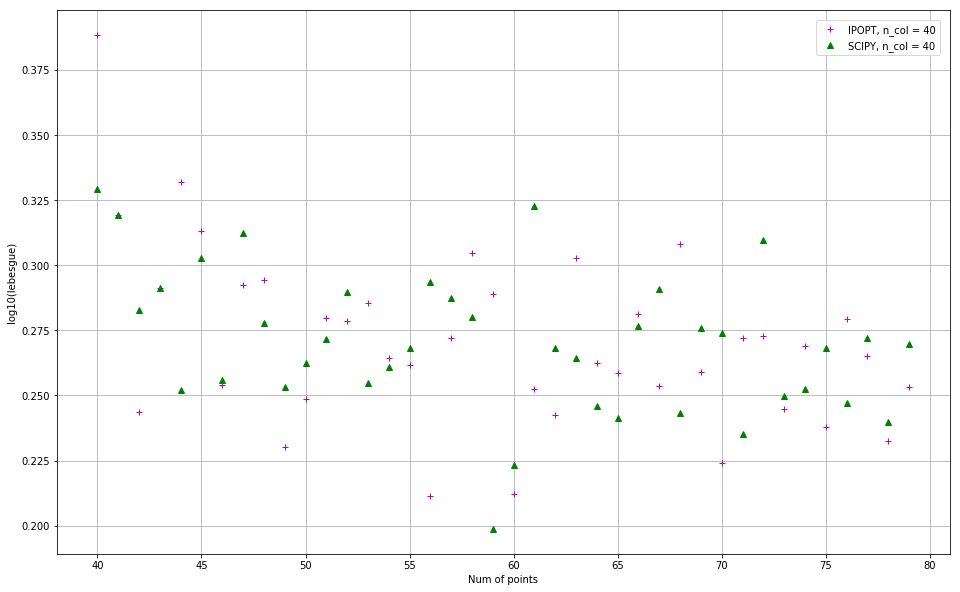

In [23]:
_, fig = plt.subplots(figsize=(16, 10))

num_col = 40
plt.plot(range(80),np.log10(IPOPT_C_error[:,num_col]),'m+', label = 'IPOPT, n_col = ' + str(num_col))
plt.plot(range(80),np.log10(SCIPY_C_error[:,num_col]),'g^', label = 'SCIPY, n_col = ' + str(num_col))
plt.xlabel('Num of points')
plt.ylabel('log10(lebesgue)')
plt.legend(ncol=1, borderaxespad=1)
plt.grid()
# plt.savefig('/Users/vitaly/Desktop/lebesgue.png', pdi = 600)
plt.show()

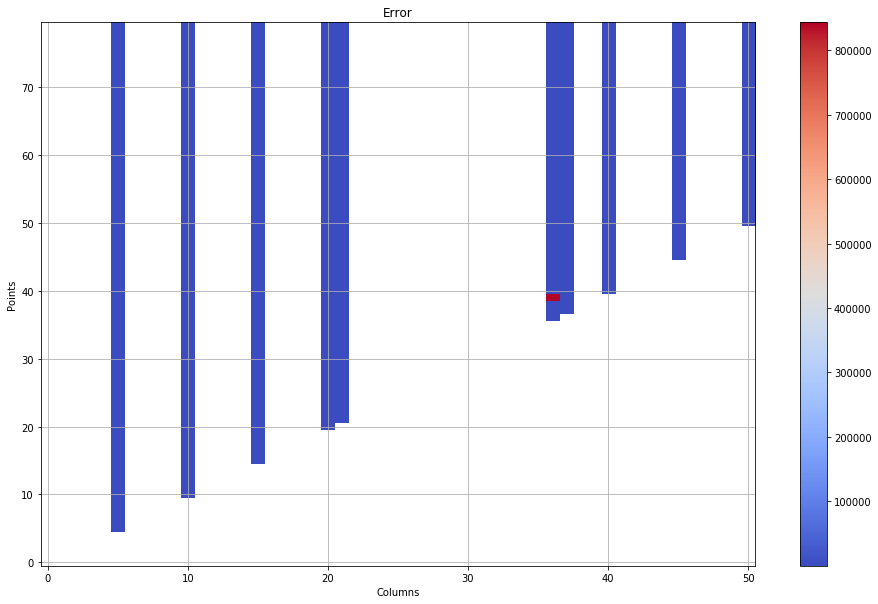

In [24]:
_, fig = plt.subplots(figsize=(16, 10))

fig = plt.imshow(IPOPT_C_error,cmap=cm.coolwarm, aspect='auto', origin='lower')
plt.xlabel('Columns')
plt.ylabel('Points')
title_obj = plt.title('Error')
plt.getp(title_obj, 'text') 
plt.colorbar(fig)
plt.grid()
# plt.savefig('/Users/vitaly/Desktop/ipopt_error.png', pdi = 600)
plt.show()

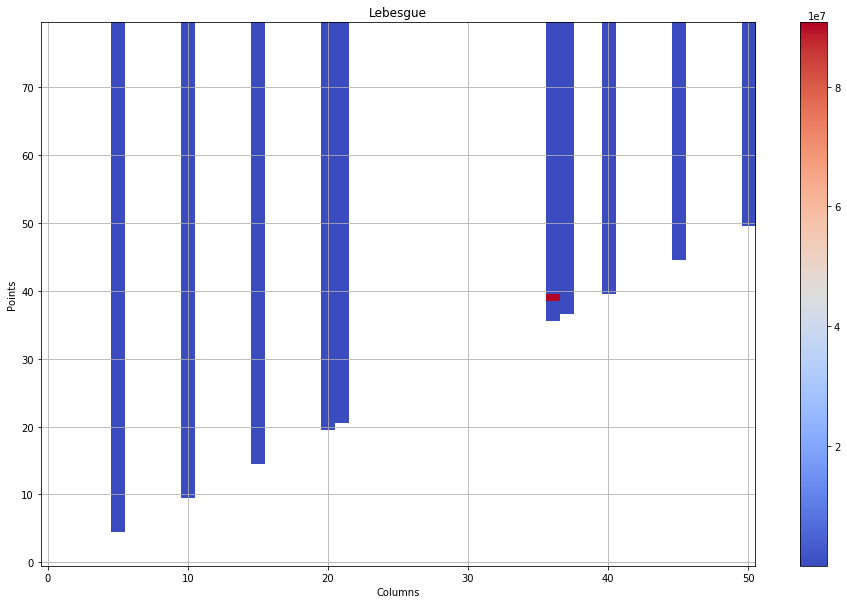

In [25]:
_, fig = plt.subplots(figsize=(16, 10))

fig = plt.imshow(IPOPT_C_lebesgue,cmap=cm.coolwarm, aspect='auto', origin='lower')
plt.xlabel('Columns')
plt.ylabel('Points')
title_obj = plt.title('Lebesgue')
plt.getp(title_obj, 'text') 
plt.colorbar(fig)
plt.grid()
# plt.savefig('/Users/vitaly/Desktop/ipopt_leb.png', pdi = 600)
plt.show()

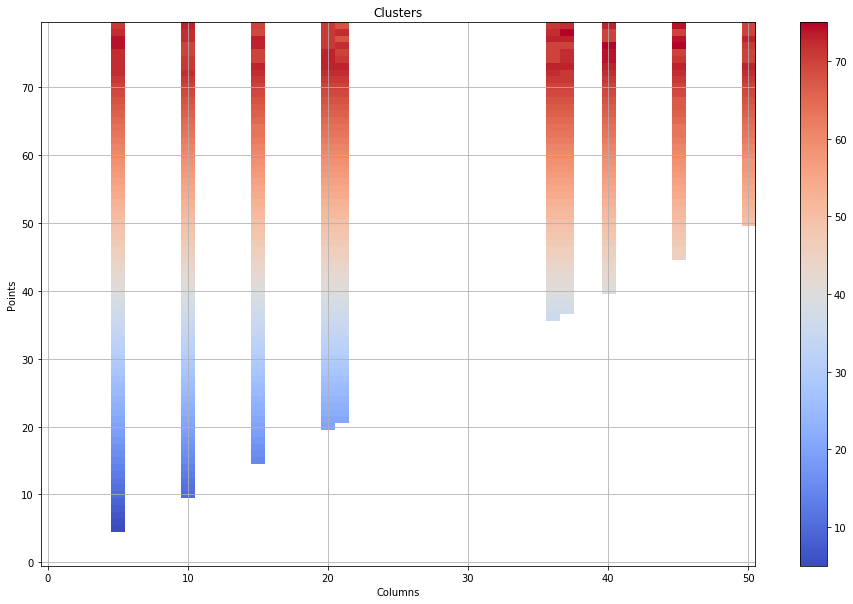

In [26]:
_, fig = plt.subplots(figsize=(16, 10))

fig = plt.imshow(IPOPT_C_clusters,cmap=cm.coolwarm, aspect='auto', origin='lower')
plt.xlabel('Columns')
plt.ylabel('Points')
title_obj = plt.title('Clusters')
plt.getp(title_obj, 'text') 
plt.colorbar(fig)
plt.grid()
# plt.savefig('/Users/vitaly/Desktop/ipopt_clust.png', pdi = 600)
plt.show()

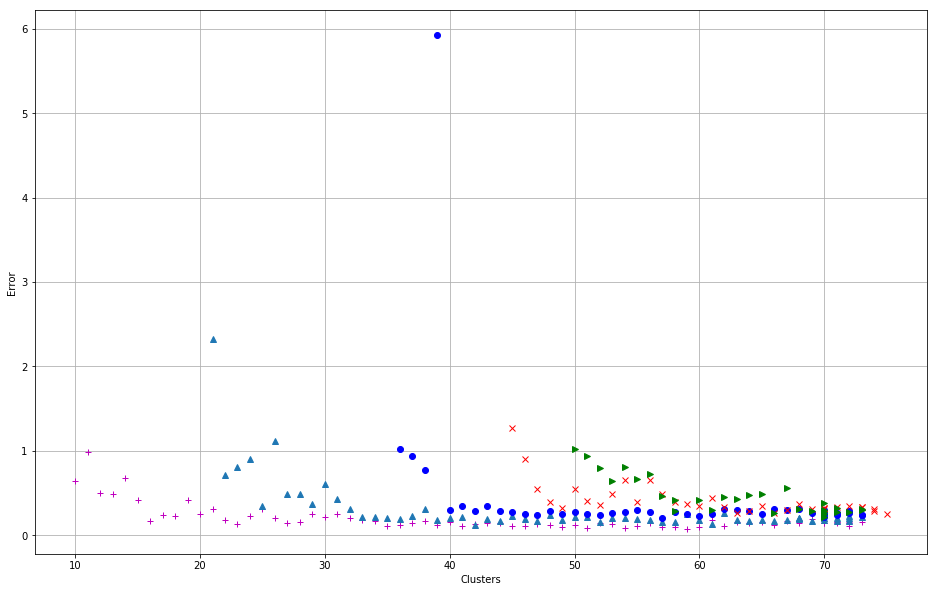

In [27]:
_, fig = plt.subplots(figsize=(16, 10))

plt.plot(IPOPT_C_clusters[:,10], np.log10(IPOPT_C_error[:,10]), 'm+')
plt.plot(IPOPT_C_clusters[:,21], np.log10(IPOPT_C_error[:,21]), '^')
plt.plot(IPOPT_C_clusters[:,36], np.log10(IPOPT_C_error[:,36]), 'bo')
plt.plot(IPOPT_C_clusters[:,40], np.log10(IPOPT_C_error[:,45]), 'rx')
plt.plot(IPOPT_C_clusters[:,50], np.log10(IPOPT_C_error[:,50]), 'g>')
plt.xlabel('Clusters')
plt.ylabel('Error')
plt.grid()
# plt.savefig('/Users/vitaly/Desktop/ipopt_.png', pdi = 600)
plt.show()

NameError: name 'C_lebesgue' is not defined

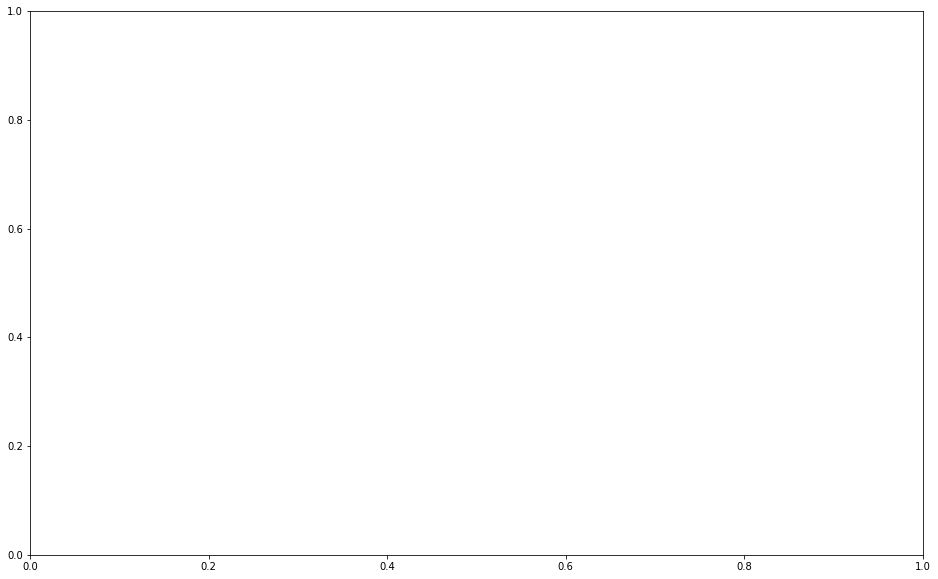

In [28]:
_, fig = plt.subplots(figsize=(16, 10))

plt.plot(C_lebesgue[:,10], C_error[:,10], 'm+')
plt.xlabel('Clusters')
plt.ylabel('Error')
plt.grid()
plt.show()

In [29]:
leb = [C_lebesgue[x,x] for x in xrange(51)]

NameError: name 'C_lebesgue' is not defined

NameError: name 'leb' is not defined

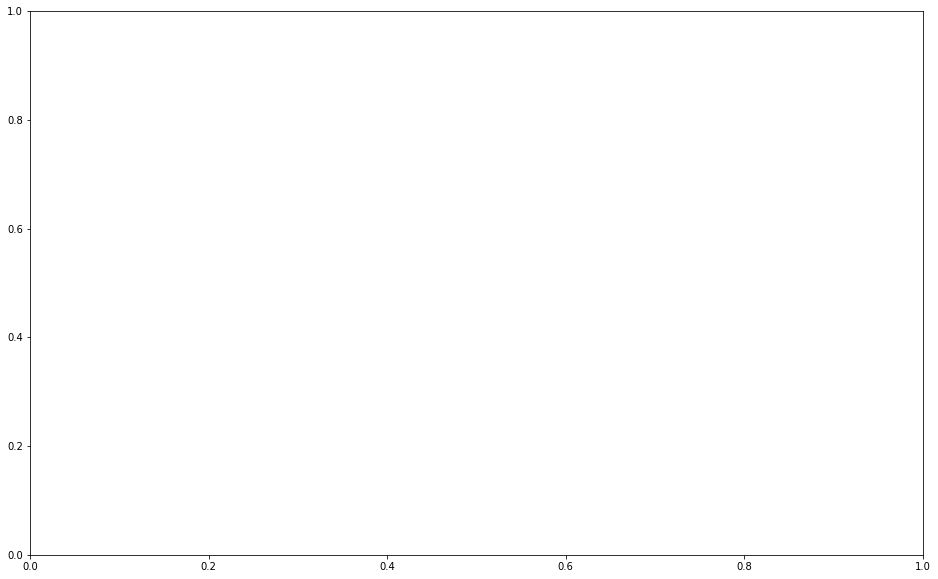

In [30]:
_, fig = plt.subplots(figsize=(16, 10))
plt.plot(xrange(51), np.log(leb), 'go', xrange(51), np.log(leb_lhs), 'rx')
plt.grid()
plt.xlabel('Columns')
plt.ylabel('Lebesgue Constant')
title_obj = plt.title('L(N_col)')
plt.getp(title_obj, 'text')
# plt.savefig('/Users/vitaly/Desktop/lebesgue_LHS_.png', pdi = 600)
plt.show()

In [ ]:
leb_lhs = np.NaN*np.ones(51)
np.random.seed(42)
test_pnts = test_points_gen(int(1e5), dim)
for col in xrange(5,56):
    x_0 = test_points_gen(col, dim, distrib='LHS')
    leb_lhs[col-5] = LebesgueConst(x_0, col, poly=gen.cheb, test_pnts=test_pnts, pow_p=1)

In [ ]:
#_, fig = plt.subplots(figsize=(16, 10))
scipy_pnts = np.load("/Users/vitaly/Downloads/maxvol-approximation/GD/cols=20_points=22_poly=cheb.npz")['pnts']
ipopt_pnts = np.load("/Users/vitaly/Downloads/maxvol-approximation/res_IPOPT/cols=20_points=22_poly=cheb.npz")['pnts']                            

In [ ]:
_, fig = plt.subplots(figsize=(16, 10))
plt.plot(scipy_pnts[:,0], scipy_pnts[:,1], 'g^')
plt.plot(ipopt_pnts[:,0], ipopt_pnts[:,1], 'ro')
plt.grid()
# plt.savefig('/Users/vitaly/Desktop/samples.png', pdi = 800)
plt.show()

In [ ]:
scipy_pnts

In [ ]:
NumOfClusters(scipy_pnts, full=True)